
# [CoE202] **[Homework3]** CNN Classification for CIFAR10 (Pytorch)
## **Training Script**

In this section, you are going to **train** CNN classification for CIFAR10 in the Pytorch framework.


# 0. Import Library


In [2]:
import numpy as np
import matplotlib.pyplot as plt # this is for importing matplotlib.pyplot (library for graph plot)
import math
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# 1. Set hyper-parameters


If you change this part, write why changing the parameter will improve the performance at the end of the .ipynb file.

In [9]:
# Set several hyperparameters and settings
batch_size = 128
n_epoch = 200
learning_rate = 0.1
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
validation_transform = transforms.Compose([
    transforms.ToTensor(),
])

shuffle = True
target_transform = None

In [10]:
seed = 1
torch.manual_seed(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Load CIFAR10 data from torchvision dataset

In [11]:
# load CIFAR10 data
train_dataset = torchvision.datasets.CIFAR10("../cifar10_data/",
                                               download=True,
                                               train=True,
                                               transform=train_transform)

validation_dataset = torchvision.datasets.CIFAR10("../cifar10_data/",
                                              download=True,
                                              train=False,
                                              transform=validation_transform, target_transform=target_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=shuffle, drop_last = True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = batch_size, shuffle=False, drop_last = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [12]:
[one_batch_data, one_batch_label] = next(iter(train_loader))
print(one_batch_data.size(), one_batch_label.size())

torch.Size([128, 3, 32, 32]) torch.Size([128])


# 3. Define functions for plotting result

In [13]:
def vismod_img(img):
    """Change the order of dimesion before visualize.

    Args:
        img (torch.Tensor) : Image to plot. Dimension of [Channel, Height, Width]
    
    Returns:
        npimg (numpy.ndarray) : Numpy array of input img. Dimension of [Height, Width, Channel]
    """
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

def show_data(data, label, classes):
    """Plot grids composed of multiple images and labels in the batch.

    Args:
        data (torch.Tensor) : Images to plot. Dimension of [Batch size, Channel, Height, Width]
        label (torch.Tensor) : Ground Truth labels correspond to Images. Dimension of [Batch size]
        classes (tuple) : Tuple with class names.
    
    Returns:
        None, matplotlib.pyplot window will appear.
    """
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(vismod_img(data[i].cpu()))
        ax.set_title(f'label : {classes[label[i].cpu().item()]}')
    plt.tight_layout()
    plt.show()

def show_inference_result(data, label, output, classes):
    """Plot grids composed of multiple images and labels in the batch, with predicted ouptut.

    Args:
        data (torch.Tensor) : Images to plot. Dimension of [Batch size, Channel, Height, Width]
        label (torch.Tensor) : Ground Truth labels correspond to Images. Dimension of [Batch size]
        label (torch.Tensor) : Predicted labels correspond to Images. Dimension of [Batch size]

    Returns:
        None, matplotlib.pyplot window will appear.
    """
    num_row = 2
    num_col = 4
    fig, axes = plt.subplots(num_row, num_col)
    for i in range(8):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(vismod_img(data[i].cpu()))
        ax.set_title(f'GT : {classes[label[i].cpu().item()]} \n output : {classes[output[i].cpu().item()]}')
    plt.tight_layout()
    plt.show()

(Training Data) ground truth example


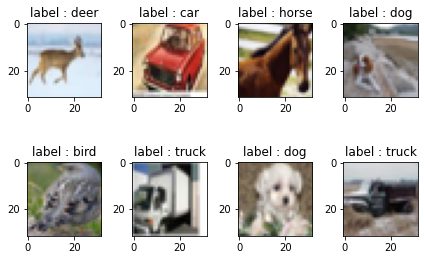

In [14]:
# show ground truth classification (one batch)
print('(Training Data) ground truth example')
show_data(one_batch_data, one_batch_label, classes)

# 4. Define CNN model




Here we have provided a classifier model in DNN.
Your task is to change this model into CNN, and achieve 93% accuracy in test data set.

If your submitted model is not CNN, no points will be given.

In [15]:
#provided simple nn
class CIFAR_Net(nn.Module): 
    def __init__(self):
        super(CIFAR_Net, self).__init__()
        # an affine operation: y = Wx + b
        self.conv1 = nn.Conv2d(3,32,3,1)       #nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        self.conv2 = nn.Conv2d(32,64,3,1) 
        self.conv3 = nn.Conv2d(64,128,3,1)      
        self.conv4 = nn.Conv2d(128,128,3,1)  
        self.fc1 = nn.Linear(3200,1000)         #nn.Linear(in_features, out_features)
        self.fc2 = nn.Linear(1000,200) 
        self.fc3 = nn.Linear(200,10)  
        self.bat1 = nn.BatchNorm2d(32)
        self.bat2 = nn.BatchNorm2d(64)
        self.bat3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(p=0.5, inplace=False)
        self.maxpool = nn.MaxPool2d(2,2)  #nn.MaxPool2d(kernel_size, stride)
        self.relu = nn.ReLU()

    def forward(self, x):
        # size of input is 3 x 32 x 32
        x = self.conv1(x) # conv1
        x = self.bat1(x)
        x = self.relu(x) # relu
        #x = self.dropout(x)
        x = self.conv2(x) # conv2
        x = self.bat2(x)
        x = self.relu(x) # relu
       # x = self.dropout(x)
        x = self.maxpool(x) # maxpool  
        x = self.conv3(x) # conv2
        x = self.bat3(x)
        x = self.relu(x) # relu
        #x = self.dropout(x)
        x = self.conv4(x) # conv2
        x = self.bat3(x)
        x = self.relu(x) # relu
        #x = self.dropout(x)
        x = self.maxpool(x) # maxpool   

        x = x.view(-1, 3200)  # view=flatten (what is the size of x at this point?)

        x = self.fc1(x) # fc1
        x = self.relu(x) # relu
        x = self.fc2(x) # fc2
        x = self.relu(x) # relu
        x = self.fc3(x) # fc3
        return x

current classification


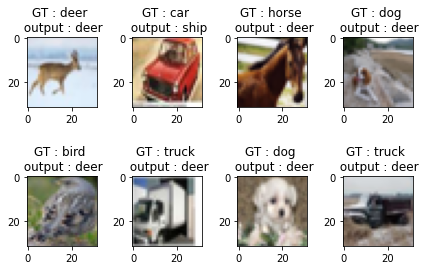

In [16]:
def weights_init(m):
    """Initialize weights.

    Args:
        m (subclass of torch.nn.modules) : module to initialize weight

    Returns:
        None, replace weights of m with initializing method
    """
    if isinstance(m, nn.Linear):
        bound = 1 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, bound)
        nn.init.uniform_(m.bias, -bound, bound)

def thresholding(prediction):
    """Find label which shows highest prediction value.
    
    Args:
        prediction (torch.tensor) : prediction tensor. Dimension of [Batch size, 10]
    
    Returns:
        pred_label (torch.tensor) : Index which shows maximum prediction value. Dimension of [Batch size]
    """
    _, pred_label = torch.max(prediction, 1)
    return pred_label

my_classifier = CIFAR_Net()  # assign classifier
my_classifier = my_classifier.to(device)
my_classifier.apply(weights_init)  # applying weights_init function to linear layers

# show the performance of untrained classifier
print('current classification')
prediction = my_classifier(one_batch_data.to(device))  # passing forward function of classifier, return prediction
show_inference_result(one_batch_data, one_batch_label, thresholding(prediction), classes)

# 5. Train CNN classifier and monitor loss and accuracy for train & validation set

You can change the optimizer to improve performance.
If you change the optimizer, please write why changing it improves performance at the end of the .ipynb file.

In [17]:
#optimizer = torch.optim.SGD(my_classifier.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(my_classifier.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.Adadelta(my_classifier.parameters(), lr=learning_rate, rho=0.9, eps=1e-06, weight_decay=0)

In [18]:
# train cnn classifier
train_loss_iter = np.zeros(n_epoch, dtype=float)  # Temporary numpy array to save loss for each epoch
validation_loss_iter = np.zeros(n_epoch, dtype=float)
train_accuracy_iter = np.zeros(n_epoch, dtype=float)  # Temporary numpy array to save accuracy for each epoch
validation_accuracy_iter = np.zeros(n_epoch, dtype=float)

criterion = torch.nn.CrossEntropyLoss()
# Assign cross-entropy loss

for epoch in range(n_epoch):  # We will iteratively find optimum
    # Training
    my_classifier.train()
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0
    for batch_idx, (x, target) in enumerate(train_loader): # current len(train_loader) = 390
        x, target = x.cuda(), target.cuda()
        prediction = my_classifier(x)  # Find output of classifier
        
        optimizer.zero_grad()  # Pytorch does not overwrite gradients, it 'accumulates' them so that we need to set gradient as 0 to update parameter correctly
        loss = criterion(prediction, target)  # Calculate cross-entropy loss between prediction and label
        loss.backward()  # Pytorch automatically back-propagate and calculate gradients
        optimizer.step()  # From calculated gradients, change parameters of classifier with SGD algorithm

        total_loss += loss.item()
        total_cnt += x.data.size(0)
        correct_cnt += (thresholding(prediction) == target.data).sum().item()
    
    accuracy = correct_cnt * 1.0 / total_cnt
    train_loss_iter[epoch] = total_loss / total_cnt
    train_accuracy_iter[epoch] = accuracy
        
    if epoch % 10 == 0:
        print(f"[{str(epoch).zfill(len(str(n_epoch)))}/{n_epoch}] Train Loss  : {train_loss_iter[epoch]:.6f}, Acc = {100*train_accuracy_iter[epoch]:.2f}%")
    
    # validation
    my_classifier.eval()
    total_loss, total_cnt, correct_cnt = 0.0, 0.0, 0.0
    for batch_idx, (x, target) in enumerate(validation_loader):
        with torch.no_grad():
            x, target = x.cuda(), target.cuda()
            
            prediction = my_classifier(x)
            loss = criterion(prediction, target)

            total_loss += loss.item()
            total_cnt += x.data.size(0)
            correct_cnt += (thresholding(prediction) == target.data).sum().item()
    
    accuracy = correct_cnt * 1.0 / total_cnt
    validation_loss_iter[epoch]  = total_loss / total_cnt
    validation_accuracy_iter[epoch] = accuracy

    if epoch % 10 == 0:
        print(f"[{str(epoch).zfill(len(str(n_epoch)))}/{n_epoch}] Validation Loss : {validation_loss_iter[epoch]:.6f}, Acc = {100*validation_accuracy_iter[epoch]:.2f}%")

RuntimeError: ignored

#6-1. Plot loss for train, validation set

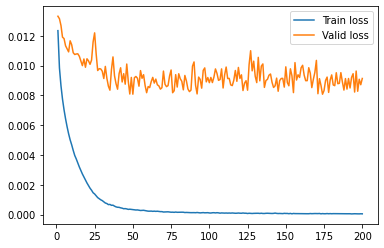

In [12]:
# show loss during training
l1, = plt.plot(range(1,n_epoch+1), train_loss_iter)
l2, = plt.plot(range(1,n_epoch+1), validation_loss_iter)
plt.legend(handles=(l1, l2), labels=('Train loss', 'Valid loss'))

#6-2. Plot accuracy for train, validation set

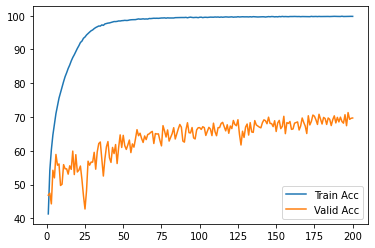

In [13]:
# show accuracy during training
l1, = plt.plot(range(1,n_epoch+1), 100*train_accuracy_iter)
l2, = plt.plot(range(1,n_epoch+1), 100*validation_accuracy_iter)
plt.legend(handles=(l1, l2), labels=('Train Acc', 'Valid Acc'))

#7. Visualize classification result of validation set after training

After training


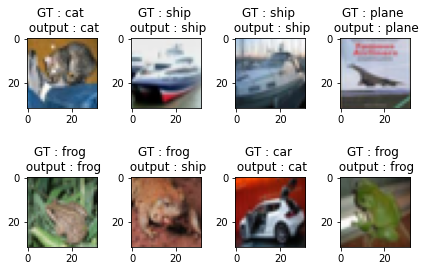

In [14]:
# For validation data
print('After training')
[one_batch_data, one_batch_label] = next(iter(validation_loader))
prediction = my_classifier(one_batch_data.to(device))
show_inference_result(one_batch_data, one_batch_label, thresholding(prediction), classes)

In [15]:

model_save_name = 'checkpoint.pth'
path = F"/content/gdrive/My Drive/{model_save_name}" 

#torch.save(checkpoint, path)
torch.save(my_classifier.state_dict(), path)

# 8. Report
Write your explanations about the code that you have implemented.

**Q1.** Write down why changing the parameter in **2. Set hyper-parameters** will improve the performance.

**Q2.** If you changed the **optimizer**, please write why changing it improves performance.

**Q3.** Please give explanations about your CNN model, and explain what helped you improve the performance. (Please discuss your trials of implementing the CNN model)

**Q4.** If you change **1. Import Library**, write the usage of the library.